In [2]:
%matplotlib ipympl
from models import *
# from models import find_index_of_nearest
from impedance.preprocessing import readCSV, readBioLogic
from impedance.visualization import plot_nyquist,plot_bode
from impedance.models.circuits import CustomCircuit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# from arbitau import give_z_for_arbitary_tau, tau_plotter
from scipy.integrate import solve_bvp

c:\Users\Gaming\AppData\Local\Programs\Python\Python311\Lib\site-packages\impedance\models\circuits\circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


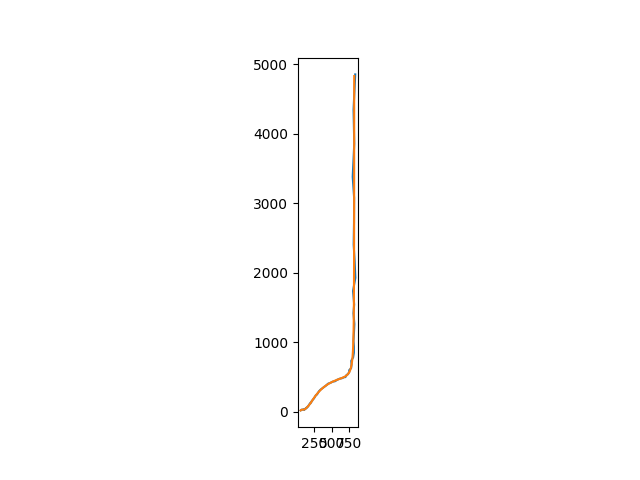

In [3]:
freq_list=np.logspace(-1,4,100)
#parameter for the TLM
Q_dt=6.61e-4
alpha_dt=1

R1_dt=1000
delta1_dt=0.12
R2_dt=2000
delta2_dt=0.17
R3_dt=2.15*194.5


#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
Rhfr=40
Rrxn=40
Qdl=1e-6
alpha2=1

cmodel=CustomCircuit(initial_guess=[R1_dt,R1_dt*Q_dt,R2_dt*Q_dt,R3_dt*Q_dt,delta1_dt,delta2_dt,alpha_dt,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMthree_1-R_1-p(R_2,CPE_1)")
zexp=cmodel.predict(frequencies=freq_list)
zexp_noise=np.real(zexp)+np.random.normal(0,0.01,(len(zexp)))*np.real(zexp)+(np.imag(zexp)+np.random.normal(0,0.01,(len(zexp)))*np.imag(zexp))*1j
fig, ax =plt.subplots()
# ax.plot([0,delta1,delta1,1],[R1,R1,R2,R2])
ax.plot(np.real(zexp_noise),-np.imag(zexp_noise))
ax.plot(np.real(zexp),-np.imag(zexp))
ax.set_aspect("equal")

In [8]:
#initial guesses for the TLM
#Double layer Capacitance inside porous electrode
Q=6.61e-4
alpha=1

R1=400
delta1=0.3
R2=400

R3=400
delta2=0.3


#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
Rhfr=200
Rrxn=200
Qdl=6.61e-4
alpha2=1

#other (for arbitrary tortuosity profile)
Rref=200
a=4
b=5

cmodel1=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMtwo_1-R_1-p(R_2,CPE_1)")

cmodel2=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,R3*Q,delta1,delta2,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMthree_1-R_1-p(R_2,CPE_1)")

In [9]:
#wt="unit"
wt="mod"
#wt="prop"

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))

cmodel1.fit(impedance=zexp_noise,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0,0,0,0,0,0,0.5),(np.inf,np.inf,np.inf,1,np.inf,np.inf,np.inf,np.inf,1)])

cmodel2.fit(impedance=zexp_noise,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0,0,0,0,0,0,0,0,0.5),(np.inf,np.inf,np.inf,np.inf,np.inf,1,np.inf,np.inf,np.inf,np.inf,1)])



zfit1=cmodel1.predict(frequencies=freq_list)
delta1_fit1=cmodel1.parameters_[3]
R1_fit1=cmodel1.parameters_[0]
R2_fit1=cmodel1.parameters_[2]*cmodel1.parameters_[0]/cmodel1.parameters_[1]

zfit2=cmodel2.predict(frequencies=freq_list)
delta1_fit2=cmodel2.parameters_[4]
delta2_fit2=cmodel2.parameters_[5]
R1_fit2=cmodel2.parameters_[0]
R2_fit2=cmodel2.parameters_[2]*cmodel2.parameters_[0]/cmodel2.parameters_[1]
R3_fit2=cmodel2.parameters_[3]*cmodel2.parameters_[0]/cmodel2.parameters_[1]

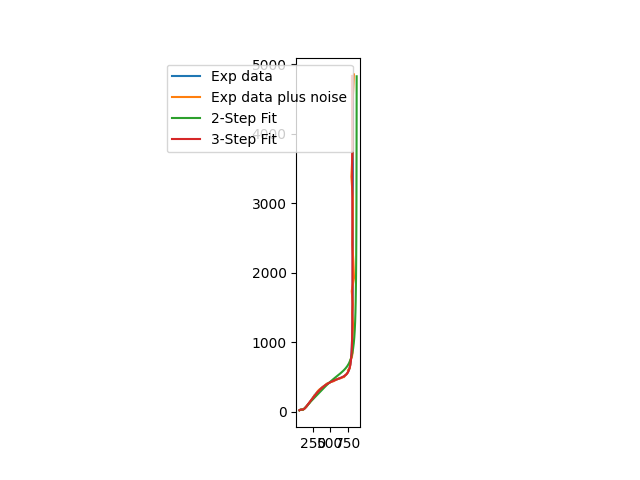

In [13]:
fig1, ax1 =plt.subplots()
ax1.plot(np.real(zexp),-np.imag(zexp),label="Exp data")
ax1.plot(np.real(zexp_noise),-np.imag(zexp_noise),label="Exp data plus noise")
ax1.plot(np.real(zfit1),-np.imag(zfit1),label="2-Step Fit")
ax1.plot(np.real(zfit2),-np.imag(zfit2),label="3-Step Fit")
ax1.legend()
ax1.set_aspect("equal")

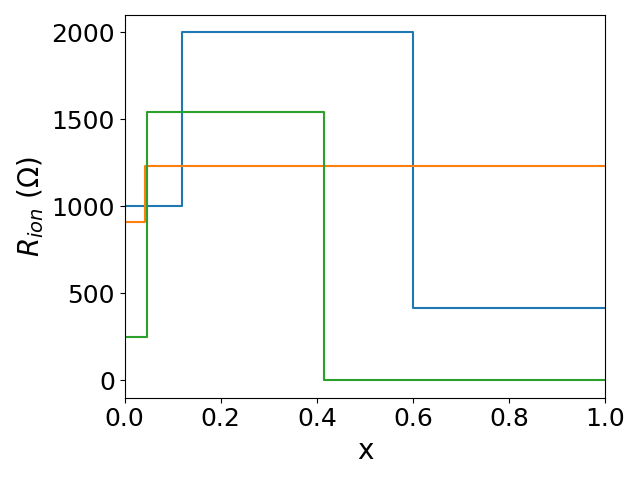

In [17]:
fig2, ax2= plt.subplots()
ax2.plot([0,delta1_dt,delta1_dt,delta2+delta1,delta2+delta1,1],[R1_dt,R1_dt,R2_dt,R2_dt,R3_dt,R3_dt],label="Original Profile")
ax2.plot([0,delta1_fit1,delta1_fit1,1],[R1_fit1,R1_fit1,R2_fit1,R2_fit1],label="2-Step Fit")
# ax2.plot([0,delta1_fit2,delta1_fit2,1],[R1_fit2,R1_fit2,R2_fit2,R2_fit2])

ax2.plot([0,delta1_fit2,delta1_fit2,delta2_fit2+delta1_fit2,delta2_fit2+delta1_fit2,1],[R1_fit2,R1_fit2,R2_fit2,R2_fit2,R3_fit2,R3_fit2],label="3-Step Fit")
# ax2.legend(fontsize=18,loc="best")
ax2.set_xmargin(0)
ax2.set_xlabel("x",fontsize=20)
ax2.set_ylabel("$R_{ion}$ $(\Omega)$",fontsize=20)
ax2.tick_params(labelsize=18)
plt.tight_layout()
fig2.savefig("3stepnoise.png",dpi=700)